<a href="https://colab.research.google.com/github/7PAM2015-0509-2023-Group-20/Kaggle-Challenge-20/blob/main/Group_project_Kaggle_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [57]:
!pip install h2o

Importing libraries

In [58]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix
import warnings
warnings.filterwarnings("ignore")


Importing libraries for H2O AutoML and NetworkX

In [59]:
import h2o
from h2o.automl import H2OAutoML
import networkx as nx

In [60]:
# Set styles
sns.set(style="whitegrid", font_scale=1.2)
pd.set_option("display.max_columns", None)

Load datasets

In [61]:
train_data = pd.read_csv("https://raw.githubusercontent.com/7PAM2015-0509-2023-Group-20/Kaggle-Challenge-20/main/train.csv")
test_data = pd.read_csv("https://raw.githubusercontent.com/7PAM2015-0509-2023-Group-20/Kaggle-Challenge-20/main/test.csv")

EDA

In [62]:
print(f"Train dataset shape: {train_data.shape}")
print(f"Test dataset shape: {test_data.shape}")

Train dataset shape: (8693, 14)
Test dataset shape: (4277, 13)


In [63]:
print(f"Duplicate rows in train dataset: {train_data.duplicated().sum()}")
print(f"Duplicate rows in test dataset: {test_data.duplicated().sum()}")

Duplicate rows in train dataset: 0
Duplicate rows in test dataset: 0


In [64]:
print("Data types in training data:")
print(train_data.dtypes)

Data types in training data:
PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object


In [65]:
print("Data types in testing data:")
print(test_data.dtypes)

Data types in testing data:
PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
dtype: object


Handle missing values

In [66]:
missing_train = train_data.isnull().sum()[train_data.isnull().sum() > 0]
missing_test = test_data.isnull().sum()[test_data.isnull().sum() > 0]
print("Missing values in train data:")
print(missing_train)
print("Missing values in test data:")
print(missing_test)

Missing values in train data:
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
dtype: int64
Missing values in test data:
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64


Feature engineering

In [67]:
def create_new_features(df):
    # PassengerId-based features
    df['Group'] = df['PassengerId'].apply(lambda x: x.split('_')[0])
    df['Member'] = df['PassengerId'].apply(lambda x: x.split('_')[1])
    df['Solo_Travel'] = df['Group'].map(df['Group'].value_counts()) == 1
    df['Group_Size'] = df['Group'].map(df['Group'].value_counts())

    # Cabin-based features
    df['Cabin'].fillna('nan/nan/nan', inplace=True)
    df['Cabin_Deck'] = df['Cabin'].apply(lambda x: x.split('/')[0])
    df['Cabin_Num'] = df['Cabin'].apply(lambda x: x.split('/')[1])
    df['Cabin_Side'] = df['Cabin'].apply(lambda x: x.split('/')[2])
    df[['Cabin_Deck', 'Cabin_Num', 'Cabin_Side']] = df[['Cabin_Deck', 'Cabin_Num', 'Cabin_Side']].replace('nan', np.nan)
    df['Cabin_Deck'].fillna(df['Cabin_Deck'].mode()[0], inplace=True)
    df['Cabin_Side'].fillna(df['Cabin_Side'].mode()[0], inplace=True)
    df['Cabin_Num'] = df['Cabin_Num'].astype(float).fillna(df['Cabin_Num'].median())

    df['Cabin_Region'] = pd.cut(df['Cabin_Num'], bins=[0, 300, 600, 900, 1200, 1500, np.inf], labels=[1, 2, 3, 4, 5, 6])

    # Age-based features
    df['Age_Group'] = pd.cut(df['Age'], bins=[-np.inf, 12, 18, 25, 32, 50, np.inf], labels=['0-12', '13-18', '19-25', '26-32', '33-50', '50+'])

    # Expenditure features
    df['Total_Expenditure'] = df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1)
    df['No_Spending'] = df['Total_Expenditure'] == 0

In [68]:
create_new_features(train_data)
create_new_features(test_data)

Fill missing values

In [69]:
cat_features = train_data.select_dtypes(include=['object', 'bool']).columns.to_list()
num_features = train_data.select_dtypes(include=['int', 'float']).columns.to_list()
cat_features.remove('Transported')

Imputing values

In [70]:
imputer_cat = SimpleImputer(strategy='most_frequent')
imputer_num = SimpleImputer(strategy='median')

train_data[cat_features] = imputer_cat.fit_transform(train_data[cat_features])
train_data[num_features] = imputer_num.fit_transform(train_data[num_features])

test_data[cat_features] = imputer_cat.transform(test_data[cat_features])
test_data[num_features] = imputer_num.transform(test_data[num_features])

In [71]:
train_df = train_data.copy()
test_df = test_data.copy()

Drop unnecessary columns

In [72]:
passenger_id = test_data['PassengerId']
train_data.drop(columns=['PassengerId', 'Name', 'Cabin'], inplace=True)
test_data.drop(columns=['PassengerId', 'Name', 'Cabin'], inplace=True)

Log transformation

In [73]:
for feature in ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']:
    train_data[feature] = np.log1p(train_data[feature])
    test_data[feature] = np.log1p(test_data[feature])

Convert boolean features

In [74]:
bool_features = ['CryoSleep', 'VIP', 'Solo_Travel', 'No_Spending', 'Cabin_Region']
train_data[bool_features] = train_data[bool_features].astype(bool)
test_data[bool_features] = test_data[bool_features].astype(bool)

**Visual representation of the datasets(EDA)**

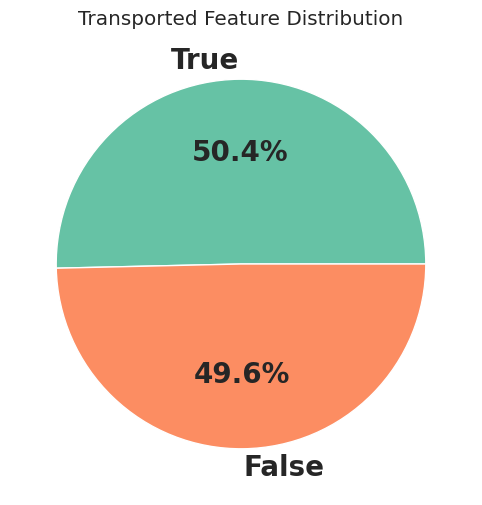

In [75]:
plt.figure(figsize=(10,6))
plt.pie(train_data["Transported"].value_counts(),labels=train_data["Transported"].value_counts().keys(),autopct="%1.1f%%",
       textprops={"fontsize":20,"fontweight":"black"},colors=sns.color_palette("Set2"))
plt.title("Transported Feature Distribution");

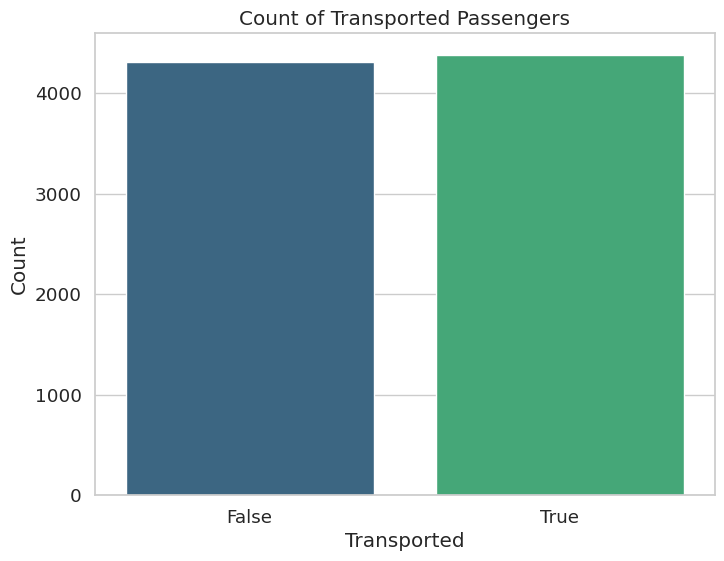

In [76]:
# EDA Visualizations

# 1. Count plot of 'Transported'
plt.figure(figsize=(8, 6))
sns.countplot(x='Transported', data=train_data, palette='viridis')
plt.title('Count of Transported Passengers')
plt.xlabel('Transported')
plt.ylabel('Count')
plt.show()


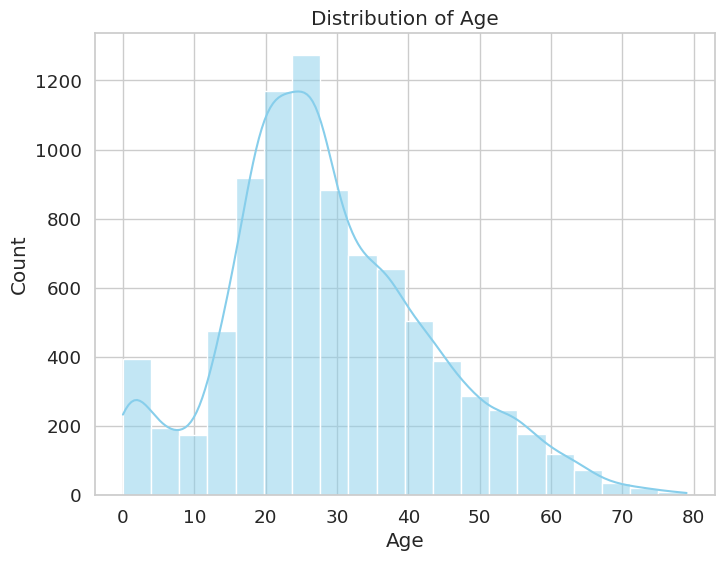

In [77]:
# 2. Distribution of 'Age'
plt.figure(figsize=(8, 6))
sns.histplot(train_data['Age'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()


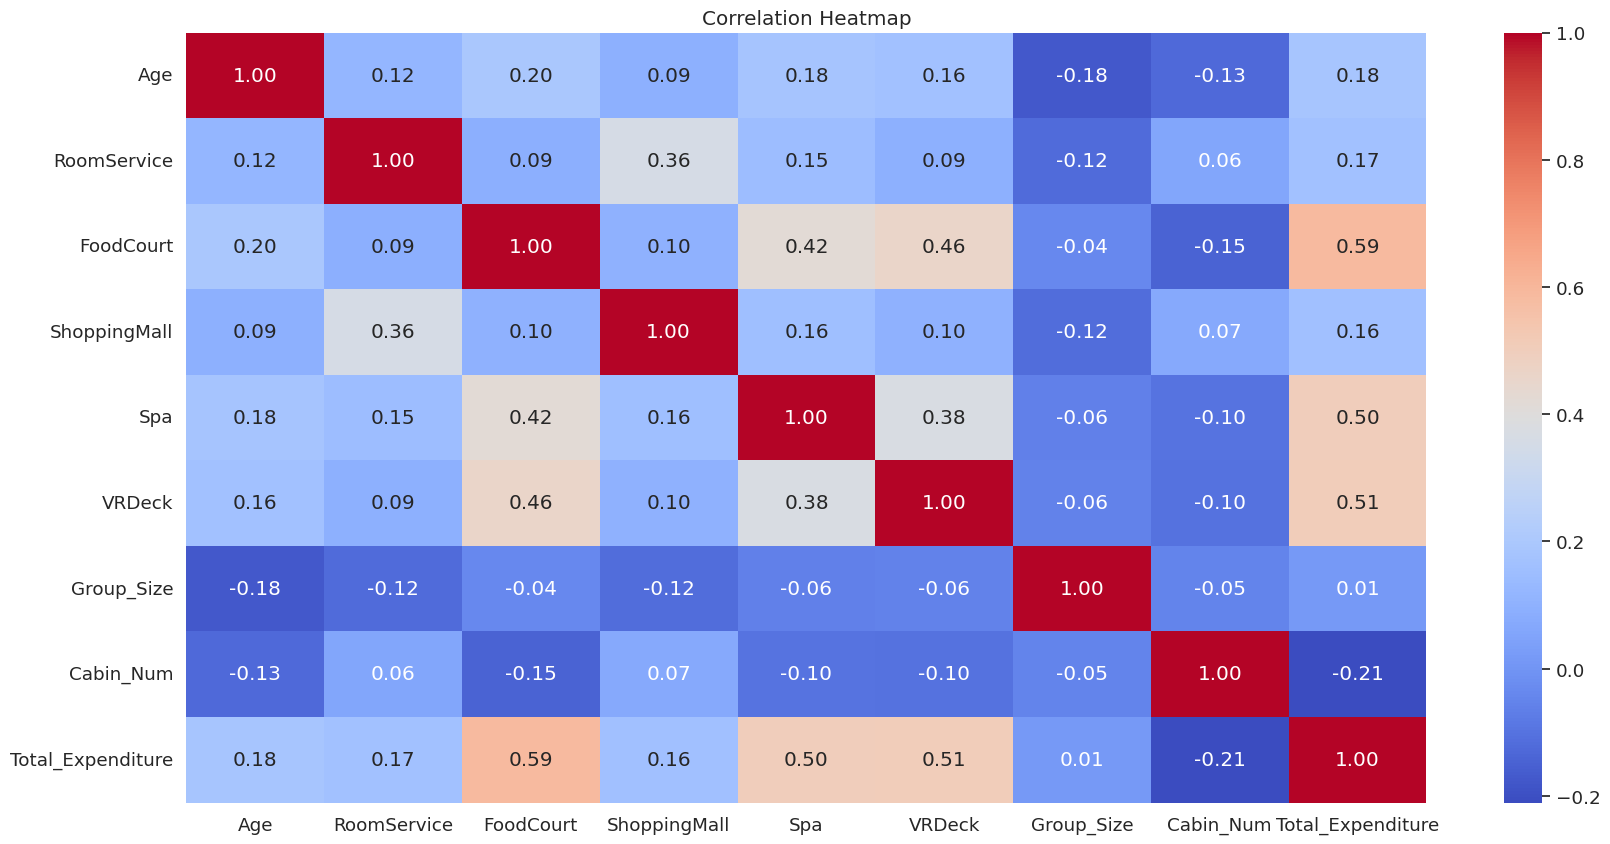

In [78]:
# 5. Correlation heatmap
# Select only numerical columns for correlation calculation
numerical_data = train_data.select_dtypes(include=['number'])

plt.figure(figsize=(20, 10))
sns.heatmap(numerical_data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

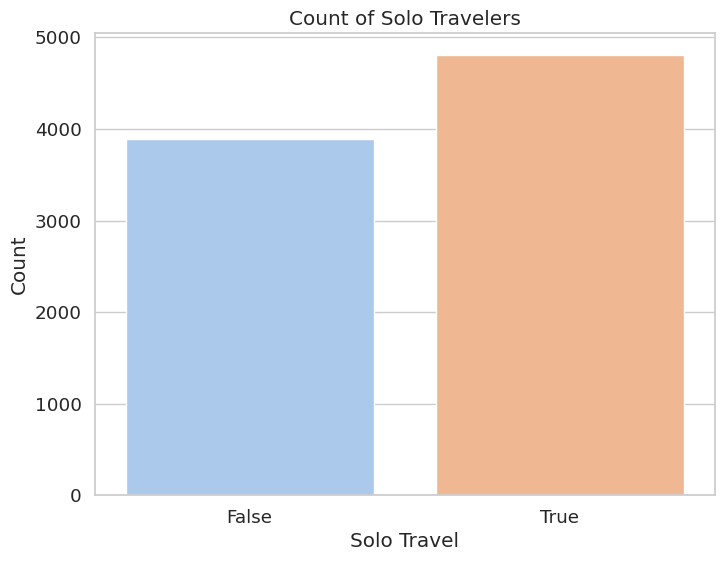

In [79]:
# Count plot of 'Solo_Travel'
plt.figure(figsize=(8, 6))
sns.countplot(x='Solo_Travel', data=train_data, palette='pastel')
plt.title('Count of Solo Travelers')
plt.xlabel('Solo Travel')
plt.ylabel('Count')
plt.show()

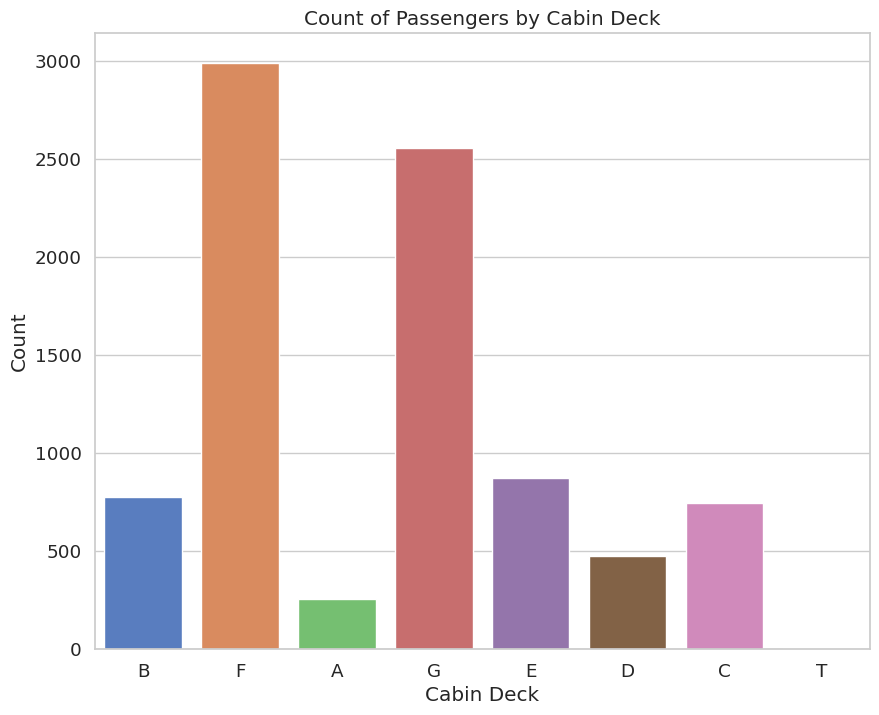

In [80]:
# Bar plot of 'Cabin_Deck'
plt.figure(figsize=(10, 8))
sns.countplot(x='Cabin_Deck', data=train_data, palette='muted')
plt.title('Count of Passengers by Cabin Deck')
plt.xlabel('Cabin Deck')
plt.ylabel('Count')
plt.show()

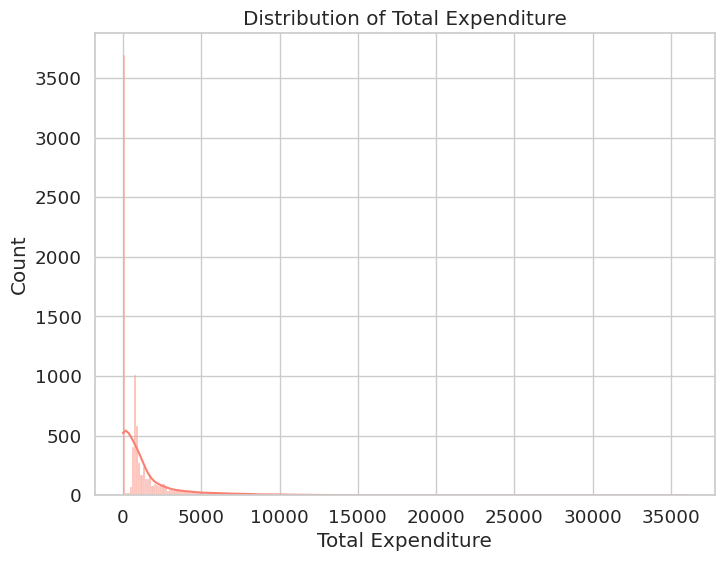

In [81]:
# Distribution plot of 'Total_Expenditure'
plt.figure(figsize=(8, 6))
sns.histplot(train_data['Total_Expenditure'], kde=True, color='salmon')
plt.title('Distribution of Total Expenditure')
plt.xlabel('Total Expenditure')
plt.ylabel('Count')
plt.show()

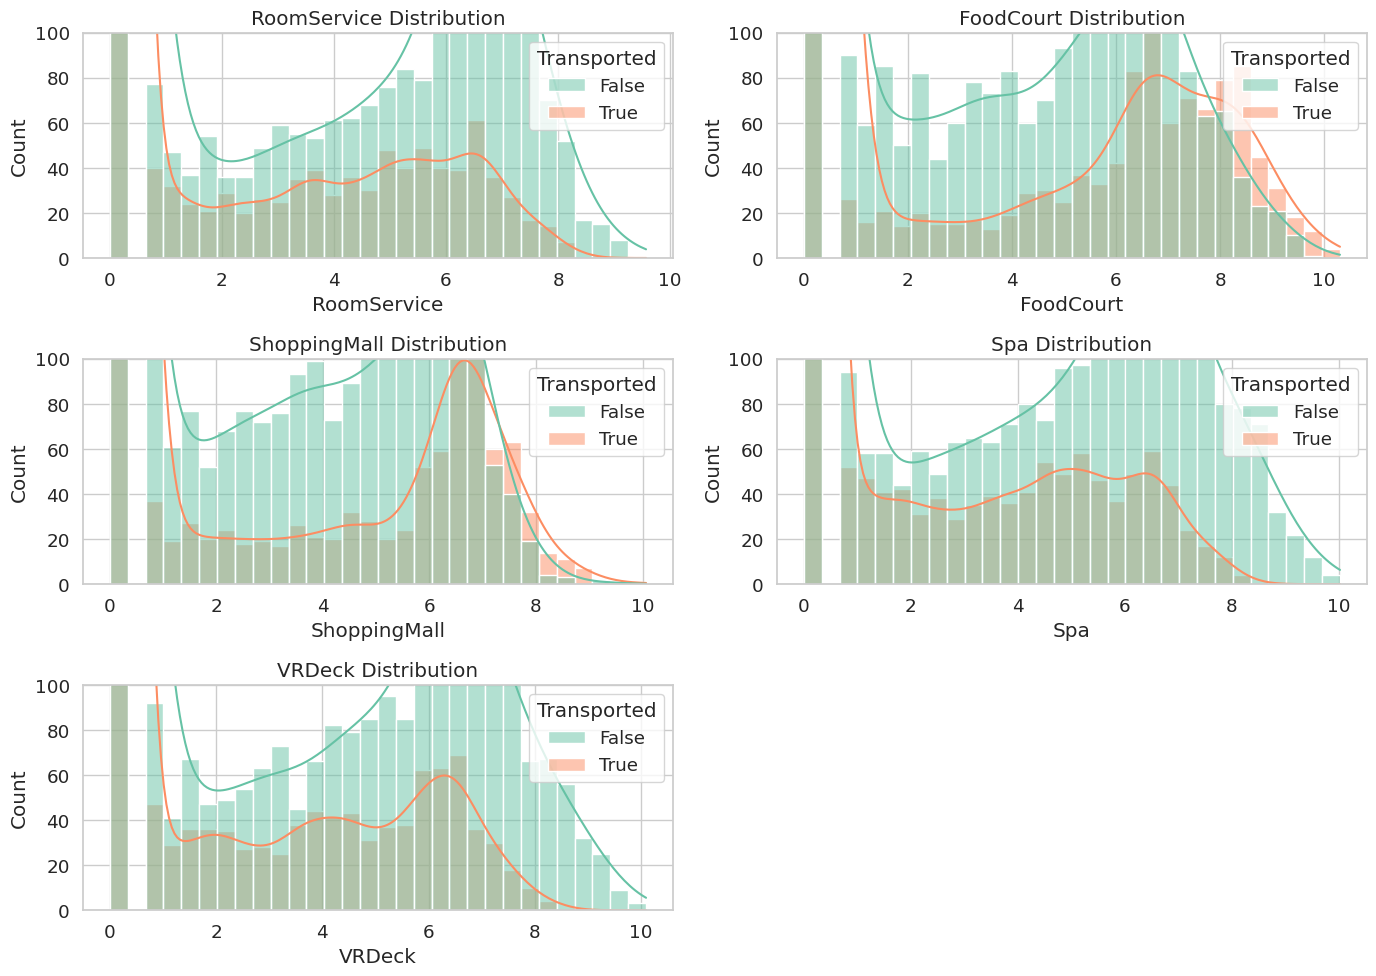

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns

exp_cols = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]

plt.figure(figsize=(14, 10))
for idx, column in enumerate(exp_cols):
    plt.subplot(3, 2, idx + 1)
    sns.histplot(train_data, x=column, hue="Transported", bins=30, kde=True, palette="Set2")
    plt.title(f"{column} Distribution")
    plt.ylim(0, 100)

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Group_Size vs Transported')

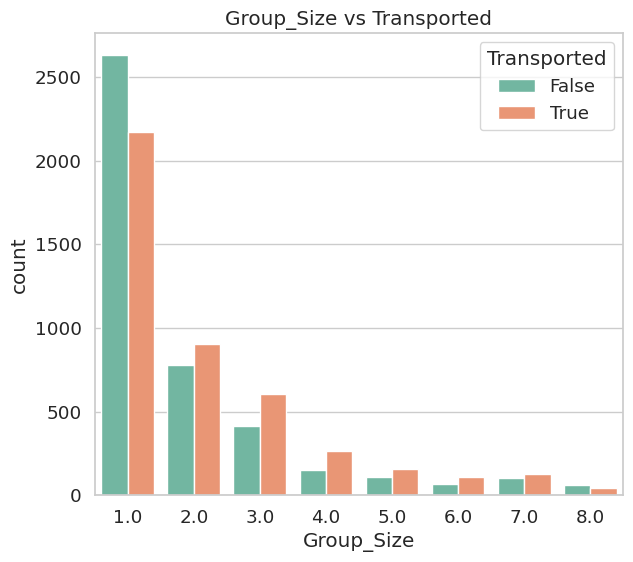

In [83]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.countplot(x="Group_Size", hue="Transported", data=train_data,palette="Set2")
plt.title("Group_Size vs Transported")

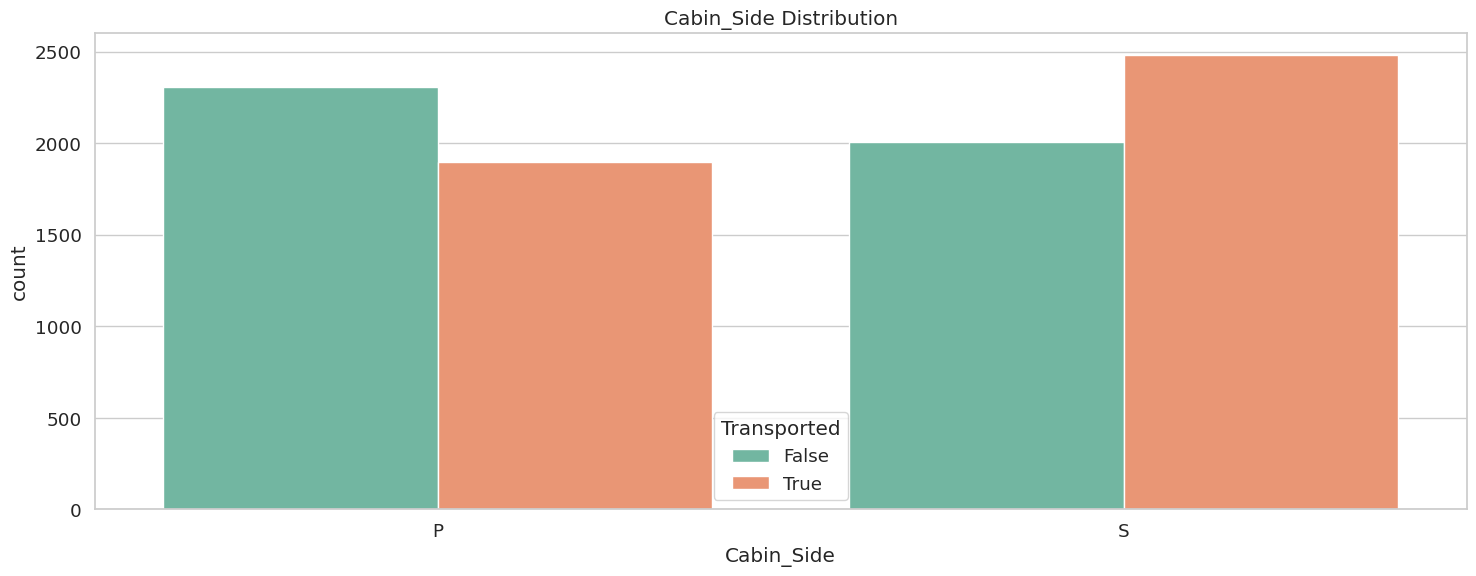

In [84]:
plt.figure(figsize=(15,6))
sns.countplot(x="Cabin_Side", hue="Transported", data=train_data, palette="Set2")
plt.title("Cabin_Side Distribution")
plt.tight_layout()
plt.show()

**Splitting dataset**

In [85]:
X = train_data.drop(columns=['Transported'])
y = train_data['Transported']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

**Standardizing data**

In [86]:
# Import necessary libraries
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Identify numerical and categorical columns
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X_train.select_dtypes(include=['object']).columns

# Create transformers for numerical and categorical features
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Fit and transform the training data
X_train = preprocessor.fit_transform(X_train)

# Transform validation and test data
X_valid = preprocessor.transform(X_valid)
test_data = preprocessor.transform(test_data)

**Initialize models**

In [87]:

models = {
    'LogisticRegression': LogisticRegression(random_state=42),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'DecisionTreeClassifier': DecisionTreeClassifier(random_state=42),
    'SVC': SVC(random_state=42),
    'GaussianNB': GaussianNB(),
    'RandomForestClassifier': RandomForestClassifier(random_state=42),
    'GradientBoostingClassifier': GradientBoostingClassifier(random_state=42),
    'AdaBoostClassifier': AdaBoostClassifier(random_state=42),
    'XGBClassifier': XGBClassifier(random_state=42),
    'LGBMClassifier': LGBMClassifier(random_state=42)
}

**Train and evaluate models**

In [88]:
results = {}
for model_name, model in models.items():
    if model_name == 'GaussianNB':
        # Convert sparse matrices to dense arrays for GaussianNB
        X_train_dense = X_train.toarray()
        X_valid_dense = X_valid.toarray()
        model.fit(X_train_dense, y_train)
        y_pred = model.predict(X_valid_dense)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_valid)

    acc = accuracy_score(y_valid, y_pred)
    prec = precision_score(y_valid, y_pred)
    rec = recall_score(y_valid, y_pred)
    f1 = f1_score(y_valid, y_pred)

    results[model_name] = {'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1': f1}

    print(f"{model_name} results:")
    print(f"Accuracy: {acc:.2f}")
    print(f"Precision: {prec:.2f}")
    print(f"Recall: {rec:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print('-' * 40)

LogisticRegression results:
Accuracy: 0.78
Precision: 0.77
Recall: 0.81
F1 Score: 0.79
----------------------------------------
KNeighborsClassifier results:
Accuracy: 0.78
Precision: 0.80
Recall: 0.76
F1 Score: 0.78
----------------------------------------
DecisionTreeClassifier results:
Accuracy: 0.79
Precision: 0.79
Recall: 0.77
F1 Score: 0.78
----------------------------------------
SVC results:
Accuracy: 0.80
Precision: 0.79
Recall: 0.83
F1 Score: 0.81
----------------------------------------
GaussianNB results:
Accuracy: 0.51
Precision: 0.51
Recall: 0.89
F1 Score: 0.65
----------------------------------------
RandomForestClassifier results:
Accuracy: 0.80
Precision: 0.84
Recall: 0.75
F1 Score: 0.79
----------------------------------------
GradientBoostingClassifier results:
Accuracy: 0.81
Precision: 0.79
Recall: 0.84
F1 Score: 0.81
----------------------------------------
AdaBoostClassifier results:
Accuracy: 0.80
Precision: 0.78
Recall: 0.84
F1 Score: 0.81
----------------------

# **Confusion Matrix and evaluation metrics**

LogisticRegression Model Evaluation:
Accuracy: 0.78
Precision: 0.77
Recall: 0.81
F1 Score: 0.79


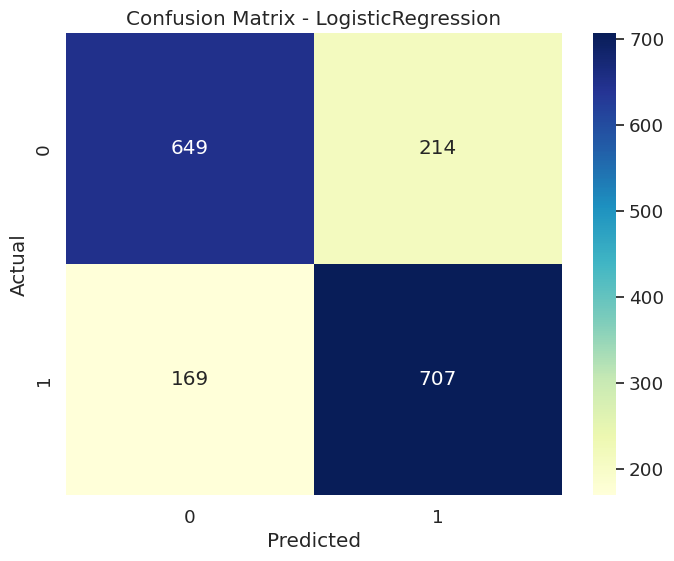

KNeighborsClassifier Model Evaluation:
Accuracy: 0.78
Precision: 0.80
Recall: 0.76
F1 Score: 0.78


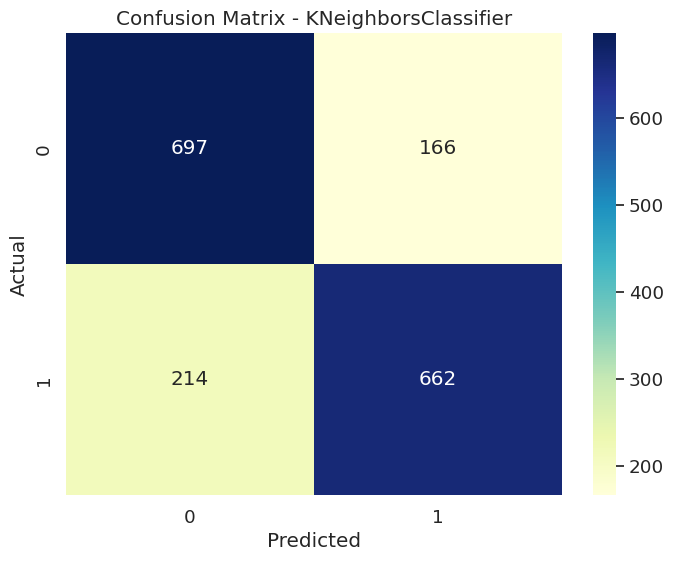

DecisionTreeClassifier Model Evaluation:
Accuracy: 0.79
Precision: 0.79
Recall: 0.77
F1 Score: 0.78


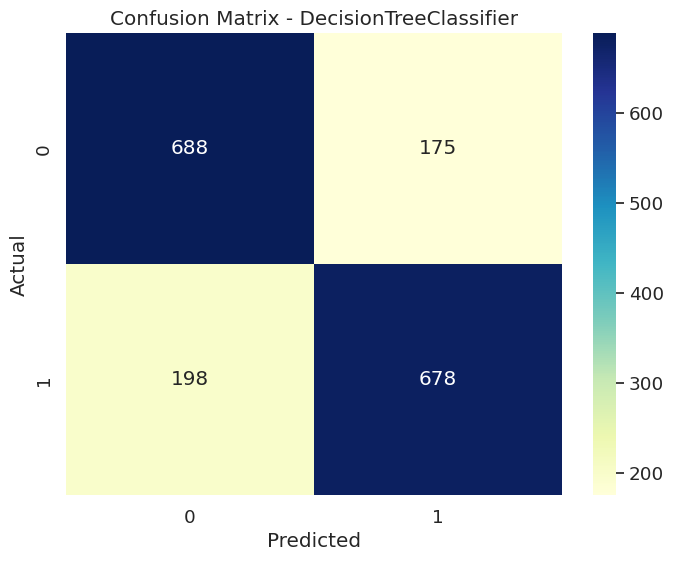

SVC Model Evaluation:
Accuracy: 0.80
Precision: 0.79
Recall: 0.83
F1 Score: 0.81


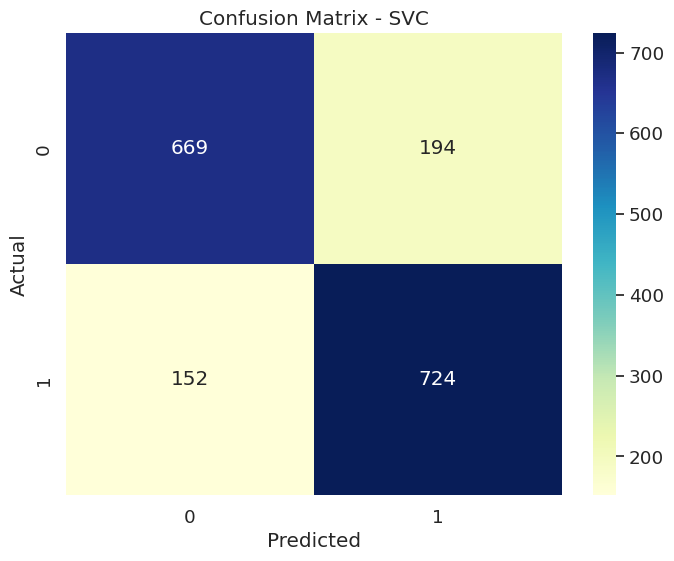

GaussianNB Model Evaluation:
Accuracy: 0.51
Precision: 0.51
Recall: 0.89
F1 Score: 0.65


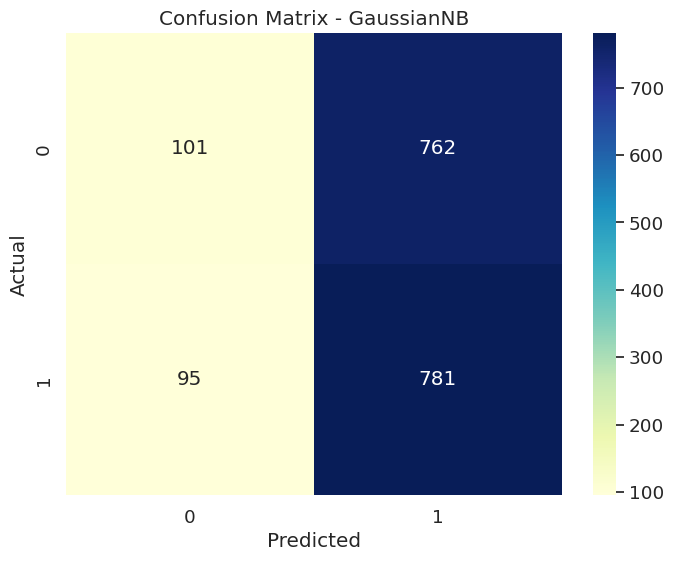

RandomForestClassifier Model Evaluation:
Accuracy: 0.80
Precision: 0.84
Recall: 0.75
F1 Score: 0.79


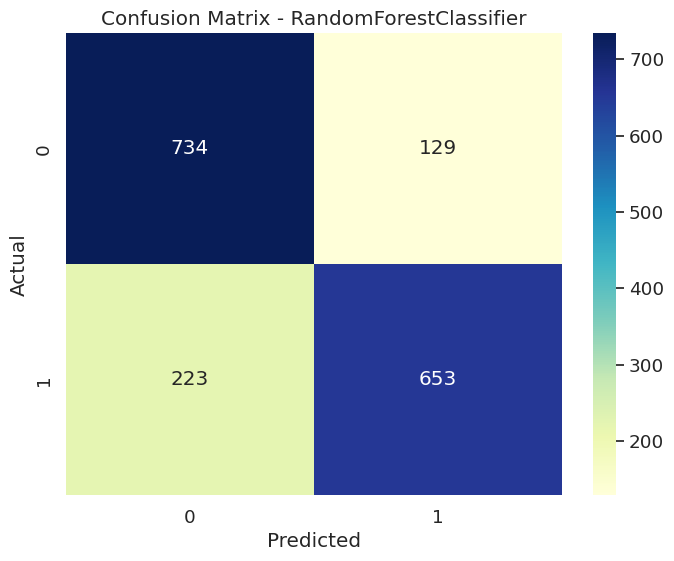

GradientBoostingClassifier Model Evaluation:
Accuracy: 0.81
Precision: 0.79
Recall: 0.84
F1 Score: 0.81


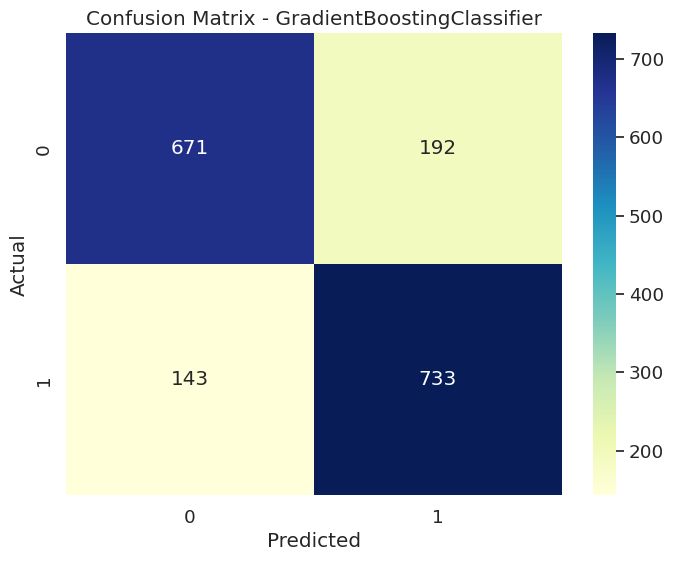

AdaBoostClassifier Model Evaluation:
Accuracy: 0.80
Precision: 0.78
Recall: 0.84
F1 Score: 0.81


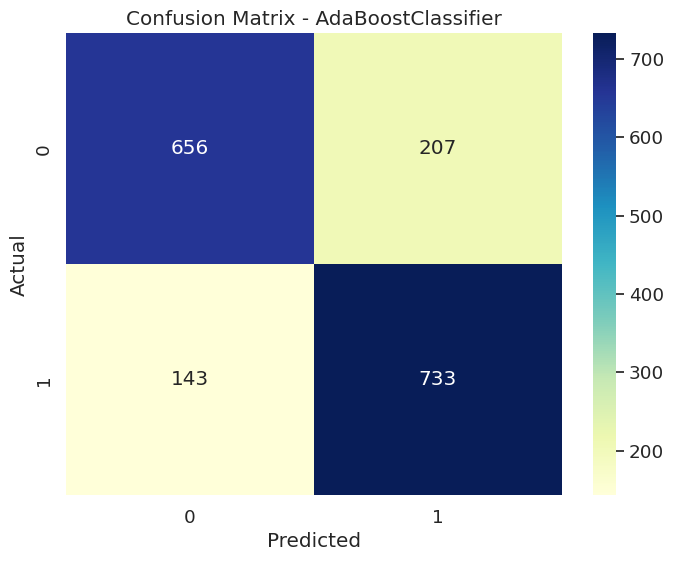

XGBClassifier Model Evaluation:
Accuracy: 0.81
Precision: 0.82
Recall: 0.80
F1 Score: 0.81


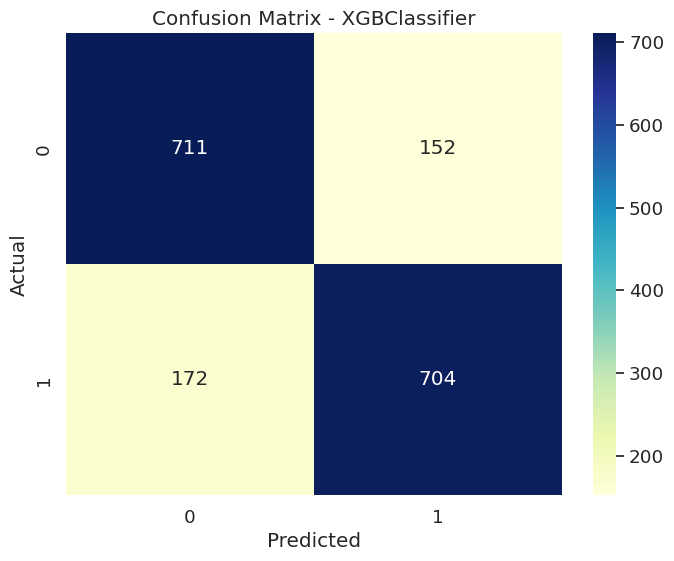

[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000957 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1917
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380
LGBMClassifier Model Evaluation:
Accuracy: 0.81
Precision: 0.81
Recall: 0.82
F1 Score: 0.81


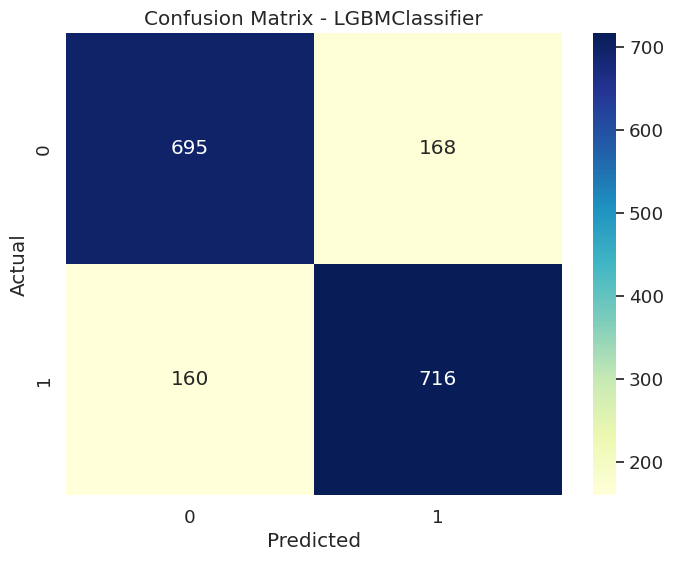

In [89]:
# Train and evaluate each model
for model_name, model in models.items():
    # Train the model
    if model_name == 'GaussianNB':
        # Convert sparse matrices to dense arrays for GaussianNB
        X_train_dense = X_train.toarray()
        X_valid_dense = X_valid.toarray()
        model.fit(X_train_dense, y_train)
        y_pred = model.predict(X_valid_dense)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_valid)

    # Calculate evaluation metrics
    acc = accuracy_score(y_valid, y_pred)
    prec = precision_score(y_valid, y_pred)
    rec = recall_score(y_valid, y_pred)
    f1 = f1_score(y_valid, y_pred)

    # Print metrics
    print(f"{model_name} Model Evaluation:")
    print(f"Accuracy: {acc:.2f}")
    print(f"Precision: {prec:.2f}")
    print(f"Recall: {rec:.2f}")
    print(f"F1 Score: {f1:.2f}")

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_valid, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGnBu')  # Change the colormap here
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# **Create a summary table for model performance**

In [90]:
model_summary = pd.DataFrame(results).T
model_summary['Model'] = model_summary.index
model_summary.reset_index(drop=True, inplace=True)
model_summary = model_summary[['Model', 'Accuracy', 'Precision', 'Recall', 'F1']]
print("Model Performance Summary:")
print(model_summary)

Model Performance Summary:
                        Model  Accuracy  Precision    Recall        F1
0          LogisticRegression  0.779758   0.767644  0.807078  0.786867
1        KNeighborsClassifier  0.781484   0.799517  0.755708  0.776995
2      DecisionTreeClassifier  0.785509   0.794842  0.773973  0.784268
3                         SVC  0.801035   0.788671  0.826484  0.807135
4                  GaussianNB  0.507188   0.506157  0.891553  0.645721
5      RandomForestClassifier  0.797585   0.835038  0.745434  0.787696
6  GradientBoostingClassifier  0.807361   0.792432  0.836758  0.813992
7          AdaBoostClassifier  0.798735   0.779787  0.836758  0.807269
8               XGBClassifier  0.813686   0.822430  0.803653  0.812933
9              LGBMClassifier  0.811386   0.809955  0.817352  0.813636


In [91]:
# Initialize H2O cluster
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,34 mins 27 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.4
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_unknownUser_2ugrwe
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.134 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [92]:
# Convert the training and test data to H2O frames
train_h2o = h2o.H2OFrame(train_data)
test_h2o = h2o.H2OFrame(test_data)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [93]:
# Define the features and target
features = [col for col in train_h2o.columns if col != 'Transported']
target = 'Transported'

In [94]:
# Convert the target column to a factor (categorical)
train_h2o[target] = train_h2o[target].asfactor()

# Run H2O AutoML
aml = H2OAutoML(max_models=20, seed=42, balance_classes=True)
aml.train(x=features, y=target, training_frame=train_h2o)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


key,value
Stacking strategy,cross_validation
Number of base models (used / total),13/20
# GBM base models (used / total),4/7
# XGBoost base models (used / total),5/6
# DRF base models (used / total),1/2
# DeepLearning base models (used / total),3/4
# GLM base models (used / total),0/1
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5


In [95]:
# View the AutoML leaderboard
lb = aml.leaderboard
print(lb)

model_id                                                      auc    logloss     aucpr    mean_per_class_error      rmse       mse
StackedEnsemble_AllModels_1_AutoML_2_20240715_141826     0.90343    0.383173  0.916029                0.19345   0.353307  0.124826
StackedEnsemble_BestOfFamily_1_AutoML_2_20240715_141826  0.903301   0.38325   0.916174                0.190564  0.353371  0.124871
GBM_1_AutoML_2_20240715_141826                           0.901498   0.387691  0.914889                0.198865  0.354975  0.126007
GBM_5_AutoML_2_20240715_141826                           0.900084   0.391467  0.913129                0.201166  0.356575  0.127145
GBM_2_AutoML_2_20240715_141826                           0.899816   0.392065  0.912655                0.199155  0.356955  0.127417
XGBoost_grid_1_AutoML_2_20240715_141826_model_2          0.899707   0.392257  0.912491                0.191193  0.357654  0.127917
GBM_grid_1_AutoML_2_20240715_141826_model_1              0.898422   0.395405  0.911

In [96]:
# Predict on the validation set (we use a portion of training data for validation)
train_h2o, valid_h2o = train_h2o.split_frame(ratios=[.8], seed=42)

# Predict on the validation set
preds_valid = aml.predict(valid_h2o)
preds_valid_df = preds_valid.as_data_frame()

# Extract true labels and predictions
y_valid_true = valid_h2o[target].as_data_frame().values.flatten()
y_valid_pred = preds_valid_df['predict'].values.flatten()

# Calculate evaluation metrics
acc = accuracy_score(y_valid_true, y_valid_pred)
prec = precision_score(y_valid_true, y_valid_pred)
rec = recall_score(y_valid_true, y_valid_pred)
f1 = f1_score(y_valid_true, y_valid_pred)

print("Validation Set Performance:")
print(f"Accuracy: {acc:.2f}")
print(f"Precision: {prec:.2f}")
print(f"Recall: {rec:.2f}")
print(f"F1 Score: {f1:.2f}")

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
Validation Set Performance:
Accuracy: 0.84
Precision: 0.79
Recall: 0.93
F1 Score: 0.86


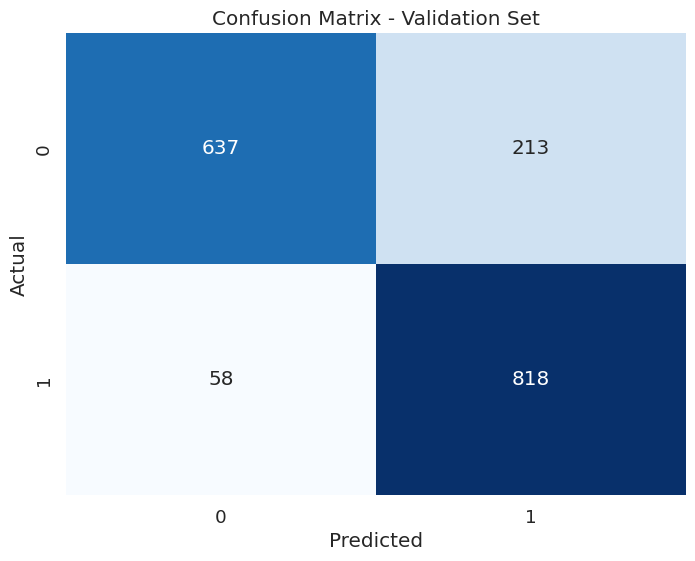

In [97]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_valid_true, y_valid_pred)

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)

# Add titles and labels
plt.title('Confusion Matrix - Validation Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Show the plot
plt.show()

In [98]:
!pip install networkx pdpbox

In [99]:
!pip install shap

In [100]:
# Import additional libraries
import networkx as nx
from pdpbox import pdp, info_plots
import shap
from sklearn.inspection import PartialDependenceDisplay

In [101]:
# Network Analysis
def create_network(df):
    G = nx.Graph()
    for _, row in df.iterrows():
        G.add_node(row['Group'], feature=row['Group_Size'])
        G.add_edge(row['PassengerId'], row['Group'])
    return G

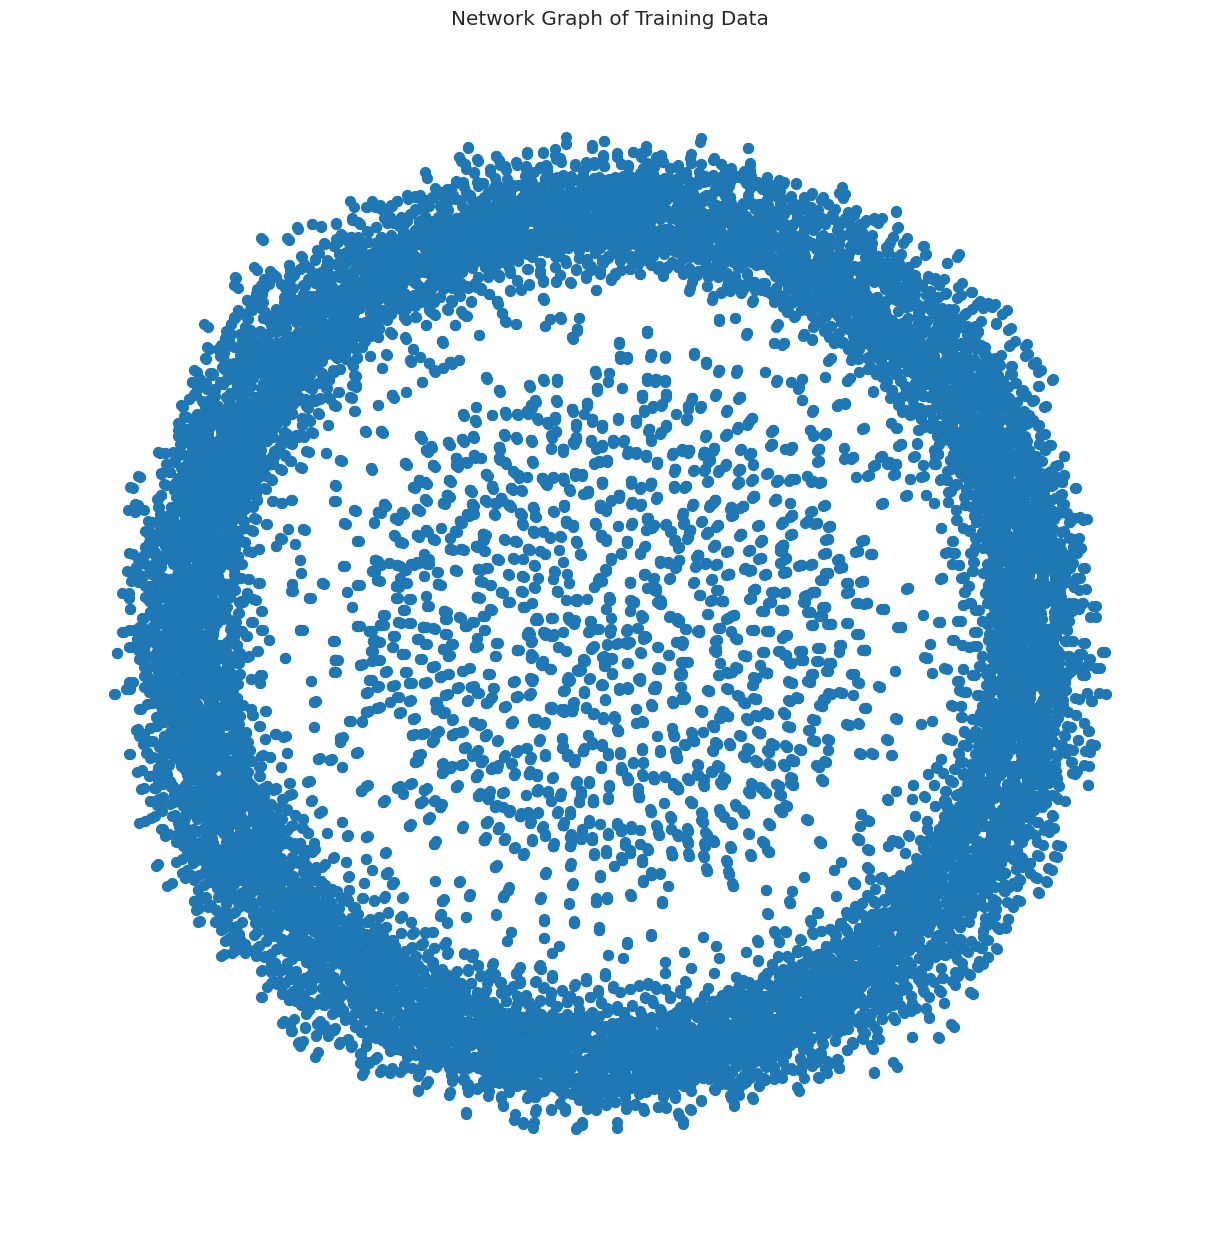

In [102]:
# Create network for train data
G_train = create_network(train_df)
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G_train)
nx.draw(G_train, pos, node_size=50, with_labels=False)
plt.title("Network Graph of Training Data")
plt.show()

In [103]:
# Identify sub-groups within the dataset
subgraphs = [G_train.subgraph(c).copy() for c in nx.connected_components(G_train)]
print(f"Number of sub-groups in training data: {len(subgraphs)}")

Number of sub-groups in training data: 6217


In [104]:
# Train-test split
X_train_new, X_valid, y_train_new, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [105]:
# Standardizing data
scaler = StandardScaler()

# Select only numerical columns for scaling
numerical_cols = X_train_new.select_dtypes(include=['number']).columns
X_train_new_numerical = X_train_new[numerical_cols]
X_valid_numerical = X_valid[numerical_cols]

X_train_new_scaled = scaler.fit_transform(X_train_new_numerical)
X_valid_scaled = scaler.transform(X_valid_numerical)

# Convert the scaled arrays back to DataFrames for easier handling
X_train_new_scaled = pd.DataFrame(X_train_new_scaled, columns=numerical_cols, index=X_train_new_numerical.index)
X_valid_scaled = pd.DataFrame(X_valid_scaled, columns=numerical_cols, index=X_valid_numerical.index)

# Fit the model (using the scaled numerical features)
best_model = RandomForestClassifier(random_state=42)
best_model.fit(X_train_new_scaled, y_train_new)

# Partial Dependence Plot (PDP)
features = ['Age', 'Total_Expenditure']  # Make sure these are in the numerical columns

In [106]:
# SHAP values
explainer = shap.TreeExplainer(best_model)

# Encode categorical features in X_valid
X_valid_encoded = pd.get_dummies(X_valid) # Use one-hot encoding or other suitable encoding method

shap_values = explainer.shap_values(X_valid_encoded)

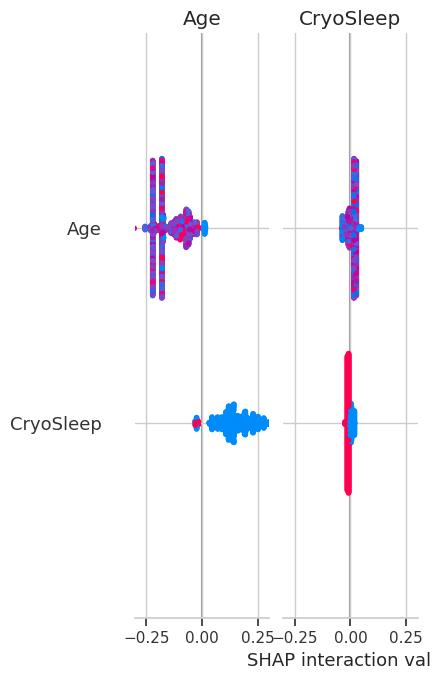

In [107]:
# Plot the SHAP summary plot
shap.summary_plot(shap_values, X_valid_encoded, feature_names=X_valid_encoded.columns)

**Comparison Graph of Model Performance**

Index(['Model', 'Accuracy', 'Precision', 'Recall', 'F1'], dtype='object')


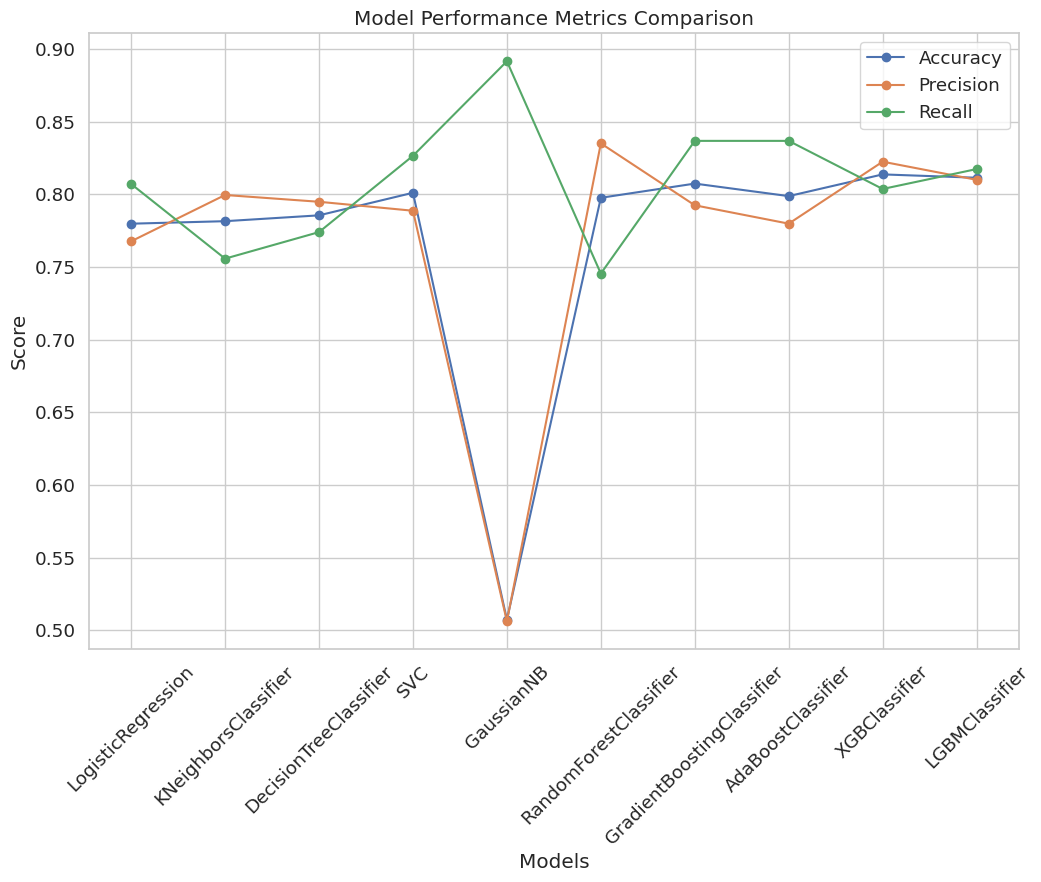

In [114]:
# Plotting combined metrics (accuracy, precision, recall, F1) for all models
plt.figure(figsize=(12, 8))

# Check the actual column names in the DataFrame
print(model_summary.columns)  # Print available columns

for metric in metrics:

    if metric in model_summary.columns:
        metric_column = metric
    elif metric.replace('-', '_') in model_summary.columns:
        metric_column = metric.replace('-', '_')
    # Add more variations as needed based on the actual column names
    else:
        print(f"Warning: Metric '{metric}' not found in DataFrame.")
        continue  # Skip plotting this metric

    plt.plot(model_names, model_summary[metric_column], marker='o', label=metric)

plt.title('Model Performance Metrics Comparison')
plt.xlabel('Models')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

In [115]:
# Assuming 'X_train' is the training data used to fit 'best_model' and
# has the necessary preprocessing steps applied
from sklearn.preprocessing import StandardScaler

# Create a scaler object, setting with_mean to False
scaler = StandardScaler(with_mean=False)

# Fit the scaler on the training data and transform it
X_train_scaled = scaler.fit_transform(X_train)

# Fit the best model on the scaled training data
best_model.fit(X_train_scaled, y_train)  # Assuming 'y_train' is your training labels

# Transform the test data using the same scaler
test_data_scaled = scaler.transform(test_data)

# Make predictions on the scaled test data
predictions = best_model.predict(test_data_scaled)

# Convert boolean predictions to 'TRUE' and 'FALSE'
predictions = ['TRUE' if pred else 'FALSE' for pred in predictions]

In [116]:
# Assuming 'best_model' has been trained and predictions are made
predictions = best_model.predict(test_data_scaled)

# Convert predictions to boolean values
predictions = predictions.astype(bool)

# Create the submission DataFrame
submission_df = pd.DataFrame({
    'PassengerId': passenger_id,
    'Transported': predictions
})

# Save the DataFrame to a CSV file
submission_df.to_csv('Sample_Submission.csv', index=False)
print("Sample_Submission.csv file has been created successfully.")

Sample_Submission.csv file has been created successfully.
